In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# 1) 하이퍼파라미터 및 디바이스 설정
batch_size = 64
learning_rate = 1e-3
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
# 2) 데이터 준비: MNIST, 픽셀값은 ToTensor()로 [0,1] 범위로 자동 정규화
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [26]:
# 3) 모델 정의: Conv→ReLU→Pool ×2, Conv→ReLU, Flatten → FC
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,  32, kernel_size=3)   # 28→26
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)   # 13→11
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)   # 5→3
        self.pool  = nn.MaxPool2d(2)                    # 26→13, 11→5
        self.fc1   = nn.Linear(64 * 3 * 3, 64)
        self.fc2   = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # → (batch,32,13,13)
        x = self.pool(torch.relu(self.conv2(x)))  # → (batch,64,5,5)
        x = torch.relu(self.conv3(x))             # → (batch,64,3,3)
        x = x.view(x.size(0), -1)                 # flatten
        x = torch.relu(self.fc1(x))
        return self.fc2(x)                        # logits

model = CNN().to(device)

In [27]:
# 4) 손실함수 & 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [28]:
# 5) 학습 루프
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    avg_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{num_epochs} — Loss: {avg_loss:.4f}")


Epoch 1/5 — Loss: 0.2190
Epoch 2/5 — Loss: 0.0581
Epoch 3/5 — Loss: 0.0413
Epoch 4/5 — Loss: 0.0332
Epoch 5/5 — Loss: 0.0275


In [29]:
 # 6) 평가
model.eval()
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
accuracy = correct / len(test_loader.dataset)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9922


In [37]:
# 7-1) 전체 예측값과 실제값 수집
all_preds  = []
all_labels = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds  = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

In [47]:
# 7-2) 클래스별 성능 리포트
print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds))



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      1.00      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



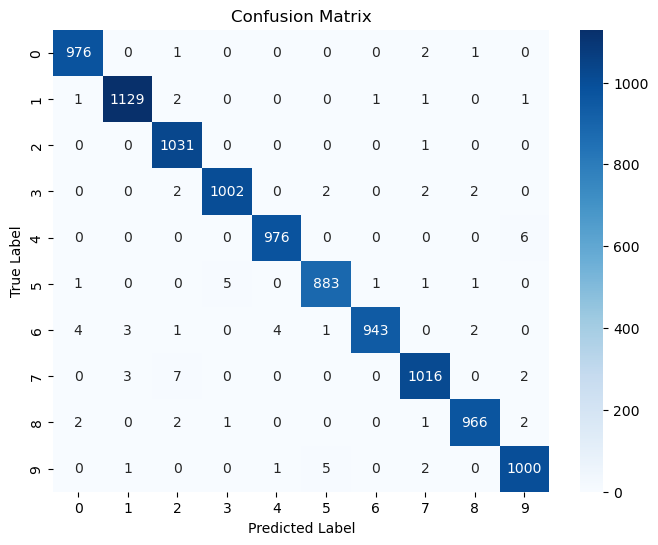

In [49]:
# 7-3) 혼동행렬 시각화
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

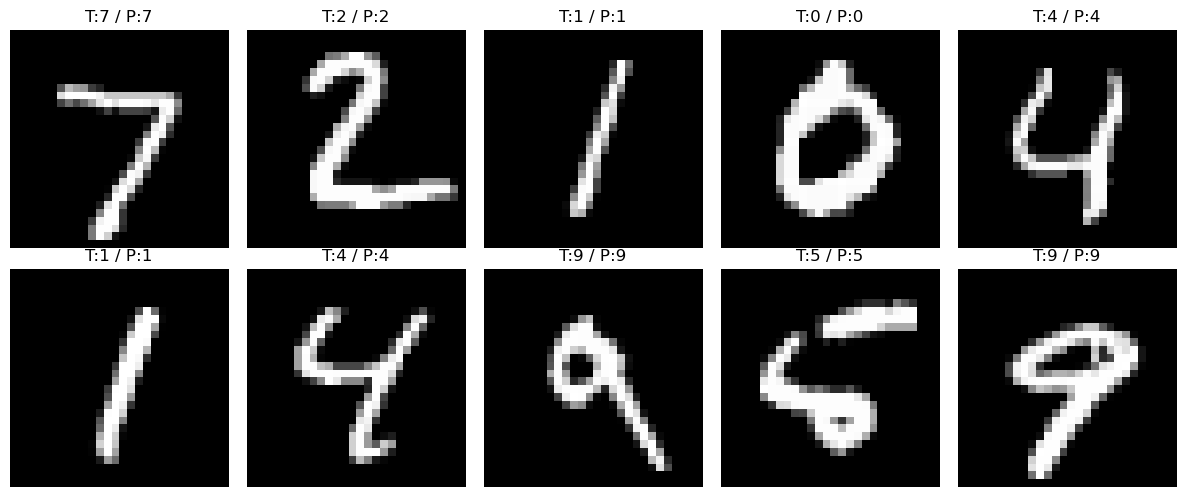

In [50]:
# 7-4) 샘플 이미지와 예측 결과 확인
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for idx, ax in enumerate(axes.flatten()):
    img, true_label = test_ds[idx]
    ax.imshow(img.squeeze(0), cmap='gray')
    ax.set_title(f"T:{true_label} / P:{all_preds[idx]}")
    ax.axis('off')
plt.tight_layout()
plt.show()